In [1]:
from griblib import AROME
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config Completer.use_jedi = False
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 125

In [4]:
# plotting parameters
temp_lim = {'min': -5.0, 'max': 5.0}
temp_lim = {'min': -70.0, 'max': 10.0}
wind_lim = {'min': 20.0, 'max': 100.0}

# parameters for great circle path
path_params = dict()
path_params['type'] = 'coordinates'
#'range-azimuth'
path_params['start'] = dict(lat=33.9621, lon=35.5635)
path_params['end'] = dict(lat=48.846135, lon=13.717930, name='I26DE')
#path_params['end'] = dict(lat=35.805200, lon=9.322900, name='I48TN')
#path_params['range'] = 1700.0e3
#path_params['azimuth'] = 26.0
dr = 2.5e3

In [5]:
#fid_grib = 'data/AROMEaut_202008040000_01700.grb' # actually 23-fc
#fid_grib = 'data/AROMEaut_202008040600_01100.grb'
fid_grib = 'data/AROMEaut_202008041200_00500.grb'
model_type = 'OPER'
# fid_grib = 'data/beirut_hres_20200804_18.grib'

In [6]:
my_atmos = AROME()
my_atmos.cycle = '-{}'.format(model_type)

In [7]:
request = [
    {'level_type': 'isobaricInhPa', 'var_list': ['t', 'u', 'v', 'w', 'q', 'z']},
    {'level_type': 'surface', 'var_list': ['orog']}
#    {'level_type': 'meanSea', 'var_list': ['msl']}
]

ds = my_atmos.read_grib(fid_grib, request, compat='override')

********************************************************************************
Reading AROME cy-OPER GRIB file [ data/AROMEaut_202008041200_00500.grb ]

Reading GRIB PV coefficients
Reading t on isobaricInhPa level
Reading u on isobaricInhPa level
Reading v on isobaricInhPa level
Reading w on isobaricInhPa level
Reading q on isobaricInhPa level
Reading z on isobaricInhPa level
Reading orog on surface level


In [8]:
(_, ds['z']) = my_atmos.geopotential_to_altitudes(ds.z)

ds['z'].attrs = {'long_name': 'Geometric altitude',
                 'standard_name': 'Geometric altitude',
                 'units': 'm'
                }

In [9]:
# Set values below orography to zero

ds = ds.where(ds.z >= ds.orog)

In [10]:
# t_fcst = (ds.valid_time).dt.strftime('%Y%m%d-%H').values
def plot_prefix(self, ds):
    t_fcst=(ds.valid_time).dt.strftime('%Y%m%d-%H').values

    title_str = '{model}{cycle} forecast {time} UT'.format(
        model=self.model, cycle=self.cycle, time=t_fcst)

    fid_prefix = '{model}{cycle}_{time}'.format(model=self.model, 
                                                cycle=self.cycle, 
                                                time=t_fcst)
    return (t_fcst, title_str, fid_prefix)

(t_fcst, title_str, fid_prefix) = plot_prefix(my_atmos, ds)

In [11]:
ds

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 23, latitude: 492, longitude: 594)
Coordinates:
    time           datetime64[ns] 2020-08-04T12:00:00
    step           timedelta64[ns] 05:00:00
  * isobaricInhPa  (isobaricInhPa) int64 1000 990 975 960 ... 300 200 150 100
  * latitude       (latitude) float64 42.98 43.0 43.02 ... 51.78 51.8 51.82
  * longitude      (longitude) float64 5.498 5.526 5.554 ... 22.05 22.07 22.1
    valid_time     datetime64[ns] 2020-08-04T17:00:00
    surface        int64 0
Data variables:
    t              (isobaricInhPa, latitude, longitude) float32 297.5 ... 218.8
    u              (isobaricInhPa, latitude, longitude) float32 11.32 ... 9.038
    v              (isobaricInhPa, latitude, longitude) float32 -14.25 ... 7.904
    w              (isobaricInhPa, latitude, longitude) float32 0.1112 ... 0....
    q              (isobaricInhPa, latitude, longitude) float32 0.007799 ... ...
    z              (isobaricInhPa, latitude, longitude) float32 77.26 ... 1.6...
    orog           (latitude, longitude, isobaricInhPa) float32 -1.254 ... 168.7

In [12]:
ds_gcp = my_atmos.extract_gcp_slice(ds, path_params, dr=dr)

In [13]:
ds_gcp

<xarray.Dataset>
Dimensions:        (distance: 980, isobaricInhPa: 23)
Coordinates:
    time           datetime64[ns] 2020-08-04T12:00:00
    step           timedelta64[ns] 05:00:00
  * isobaricInhPa  (isobaricInhPa) int64 1000 990 975 960 ... 300 200 150 100
    valid_time     datetime64[ns] 2020-08-04T17:00:00
    surface        int64 0
    longitude      (distance) float64 35.56 35.55 35.53 ... 13.77 13.75 13.72
    latitude       (distance) float64 33.96 33.98 34.0 ... 48.82 48.83 48.85
  * distance       (distance) float64 0.0 2.5e+03 ... 2.445e+06 2.447e+06
    azimuth        (distance) float64 -40.94 -40.95 -40.96 ... -55.58 -55.6
Data variables:
    t              (isobaricInhPa, distance) float64 nan nan nan ... 219.3 219.2
    u              (isobaricInhPa, distance) float64 nan nan nan ... 4.391 4.286
    v              (isobaricInhPa, distance) float64 nan nan nan ... 4.132 4.171
    w              (isobaricInhPa, distance) float64 nan nan ... 0.013 0.02691
    q              (isobaricInhPa, distance) float64 nan nan ... 3.293e-06
    z              (isobaricInhPa, distance) float64 nan nan ... 1.659e+04
    orog           (distance, isobaricInhPa) float64 nan nan nan ... 939.1 939.1

In [14]:
# Temperature (in degrees Celcius)
temperature = ds_gcp['t'].squeeze() - 273.15

temperature.attrs= {'long_name': 'temperature',
                    'units' : 'deg C',
                    'standard_name': 'air_temperature'}

# Wind speed
windspeed = np.sqrt(ds_gcp.u**2+ds_gcp.v**2).squeeze()
#windspeed = windspeed.where(windspeed > 0.985*wind_lim['min'])
windspeed.attrs= {'long_name': 'wind speed',
                    'units' : 'm/s',
                    'standard_name': 'wind_speed'}

In [15]:
lons = ds_gcp.longitude.values
lats = ds_gcp.latitude.values
coord_str = '({slo:.1f}E,{sla:.1f}N) > ({elo:.1f}E,{ela:.1f}N)'.format(
    slo=lons[0], sla=lats[0], elo=lons[-1], ela=lats[-1])
title_str = '{model}{cycle} fcst {time} UT - gcp {coords}'.format(
    model=my_atmos.model, cycle=my_atmos.cycle, time=t_fcst, coords=coord_str)


fid_prefix = '{model}{cycle}_{time}'.format(model=my_atmos.model, 
                                            cycle=my_atmos.cycle, 
                                            time=t_fcst)

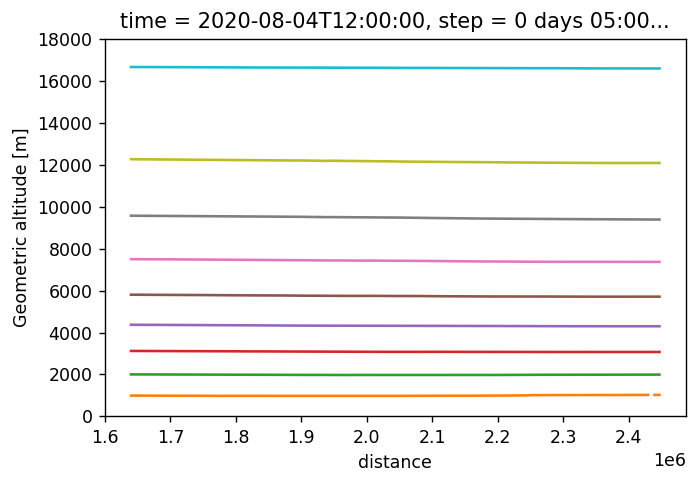

In [16]:
alt = ds_gcp['z']
alt.sel(isobaricInhPa=1000).plot()
alt.sel(isobaricInhPa=900).plot()
alt.sel(isobaricInhPa=800).plot()
alt.sel(isobaricInhPa=700).plot()
alt.sel(isobaricInhPa=600).plot()
alt.sel(isobaricInhPa=500).plot()
alt.sel(isobaricInhPa=400).plot()
alt.sel(isobaricInhPa=300).plot()
alt.sel(isobaricInhPa=200).plot()
alt.sel(isobaricInhPa=100).plot()
plt.ylim([0, 18e3])
plt.show()

In [17]:
(cT, wa, wc, ce) = my_atmos.infrasound_propagation_conditions(t=ds_gcp.t,
                                                              u=ds_gcp.u,
                                                              v=ds_gcp.v,
                                                              azimuth=ds_gcp.azimuth)
#c0 = ce.sel(isobaricInhPa=1000)
# Compute c0 first level above ground
a = ce.notnull().idxmax(dim='isobaricInhPa')
c0 = ce.sel(dict(isobaricInhPa=a))

cr = my_atmos.effective_sound_speed_ratio(ce, c0)

ds_gcp = xr.merge([cT.to_dataset(),
                   wa.to_dataset(),
                   wc.to_dataset(),
                   ce.to_dataset(),
                   cr.to_dataset(),
                   ds_gcp],
                   compat='override')

In [18]:
nlev = ds_gcp.dims['isobaricInhPa']
nrng = ds_gcp.dims['distance']

x = np.broadcast_to(np.expand_dims(ds_gcp.distance, axis=0), shape=(nlev, nrng)) / 1e3
y = ds_gcp.z / 1e3
print(x.shape, y.shape)

(23, 980) (23, 980)


In [19]:
ds_gcp

<xarray.Dataset>
Dimensions:        (distance: 980, isobaricInhPa: 23)
Coordinates:
    time           datetime64[ns] 2020-08-04T12:00:00
    step           timedelta64[ns] 05:00:00
  * isobaricInhPa  (isobaricInhPa) int64 1000 990 975 960 ... 300 200 150 100
    valid_time     datetime64[ns] 2020-08-04T17:00:00
    surface        int64 0
    longitude      (distance) float64 35.56 35.55 35.53 ... 13.77 13.75 13.72
    latitude       (distance) float64 33.96 33.98 34.0 ... 48.82 48.83 48.85
  * distance       (distance) float64 0.0 2.5e+03 ... 2.445e+06 2.447e+06
    azimuth        (distance) float64 -40.94 -40.95 -40.96 ... -55.58 -55.6
Data variables:
    cT             (isobaricInhPa, distance) float64 nan nan nan ... 296.9 296.8
    wa             (isobaricInhPa, distance) float64 nan nan ... -1.286 -1.18
    wc             (isobaricInhPa, distance) float64 nan nan ... -5.89 -5.863
    ce             (isobaricInhPa, distance) float64 nan nan nan ... 295.6 295.7
    cr             (isobaricInhPa, distance) float64 nan nan ... 0.8816 0.8867
    t              (isobaricInhPa, distance) float64 nan nan nan ... 219.3 219.2
    u              (isobaricInhPa, distance) float64 nan nan nan ... 4.391 4.286
    v              (isobaricInhPa, distance) float64 nan nan nan ... 4.132 4.171
    w              (isobaricInhPa, distance) float64 nan nan ... 0.013 0.02691
    q              (isobaricInhPa, distance) float64 nan nan ... 3.293e-06
    z              (isobaricInhPa, distance) float64 nan nan ... 1.659e+04
    orog           (distance, isobaricInhPa) float64 nan nan nan ... 939.1 939.1

In [30]:
def plot_infrasound_profile(self, ds_gcp, layer):
    (t_fcst, model_str, fid_prefix) = plot_prefix(self, ds_gcp)
    
    n_plots = 3

    z_lim = {'min': layer['z_min'], 'max': layer['z_max']}
    z_ticks = np.arange(z_lim['min'], z_lim['max'], layer['dz'])
    x_elevation = ds_gcp.distance / 1e3
    y_elevation = ds_gcp.orog.sel(isobaricInhPa=100) / 1e3

    # plot it
    fig, ax = plt.subplots(n_plots, 2, sharey=True, figsize=(9,6), gridspec_kw={'width_ratios': [1, 5]})
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.075, hspace=0.5)

    if layer['fid'] == 'surface':
        ct_min = 320
        ct_max = 350
    else:
        ct_min = 290
        ct_max = 350
    ax[0,0].plot(ds_gcp['cT'], y.mean(axis=1), color='gray')
    ax[0,0].plot(ds_gcp['cT'].mean(axis=1), y.mean(axis=1), color='red')
    ax[0,0].set_xlim([ct_min, ct_max])
    ax[0,0].set_xlabel('$c_T$ [m/s]')
    im = ax[0,1].pcolor(x, y, ds_gcp['cT'],
                            cmap='Spectral_r',
                            vmin=ct_min, vmax=ct_max)
    ax[0,1].contour(x, y, ds_gcp['cT'], 
                    colors='black', levels=np.arange(300., ct_max, 5.), alpha=0.1)
    plt.colorbar(im,ax=ax[0,1],label='$c_T$ [m/s]')

    if layer['fid'] == 'surface':
        wa_min = -20
        wa_max = 20
    else:
        wa_min = -50
        wa_max = 50
    ax[1,0].plot(ds_gcp['wa'], y.mean(axis=1), color='gray')
    ax[1,0].plot(ds_gcp['wa'].mean(axis=1), y.mean(axis=1), color='red')
    ax[1,0].set_xlim([wa_min, wa_max])
    ax[1,0].set_xlabel('$w_{a}$ [m/s]')
    im = ax[1,1].pcolor(x, y, ds_gcp['wa'],
                            cmap='RdBu_r',
                            vmin=wa_min, vmax=wa_max)
    plt.colorbar(im,ax=ax[1,1],label='$w_{a}$ [m/s]')
    ax[1,1].contour(x, y, ds_gcp['wa'], 
                    colors='black', levels=np.arange(wa_min, wa_max, 5.), alpha=0.1)

    if layer['fid'] == 'surface':
        cr_min = 0.90
        cr_max = 1.05
    else:
        cr_min = 0.8
        cr_max = 1.06
    ax[2,0].plot(ds_gcp['cr'], y.mean(axis=1), color='gray')
    ax[2,0].plot(ds_gcp['cr'].mean(axis=1), y.mean(axis=1), color='red')
    ax[2,0].set_xlim([cr_min, cr_max])
    ax[2,0].set_xlabel('c$_{e} ratio$ [-]')
    xx = ds_gcp['cr'].where(ds_gcp['cr'] > 0.99)
    im = ax[2,1].pcolor(x, y, xx,
                            cmap='inferno_r',
                            vmin=0.99, vmax=cr_max)
    ax[2,1].contour(x, y, ds_gcp['cr'],
                    colors='black', levels=np.arange(0.99, 1.05, 0.01), alpha=0.1)
    plt.colorbar(im,ax=ax[2,1],label='c$_{e}$ ratio [-]')


    for i in range(0,n_plots):
        ax[i,0].set_ylabel('Altitude [km]')
        ax[i,1].fill_between(x_elevation, 0, y_elevation,
                             facecolor='gray', alpha=0.9)
        for j in range(0,2):
            ax[i,j].set_ylim(z_lim['min'], z_lim['max'])
            ax[i,j].set_yticks(z_ticks)

    ax[2,1].set_xlabel('Range [km]')
    #ax[0,1].set_title(title_str)

    fig.suptitle(title_str)
    fig.tight_layout()

    fid_gcp = '{}_{}_profile.png'.format(fid_prefix, layer['fid'])
    fig.savefig(fid_gcp, facecolor='white', bbox_inches = 'tight')

    plt.show()

<ipython-input-30-eb9a09971264>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[0,1].pcolor(x, y, ds_gcp['cT'],
<ipython-input-30-eb9a09971264>:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[1,1].pcolor(x, y, ds_gcp['wa'],
<ipython-input-30-eb9a09971264>:60: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pa

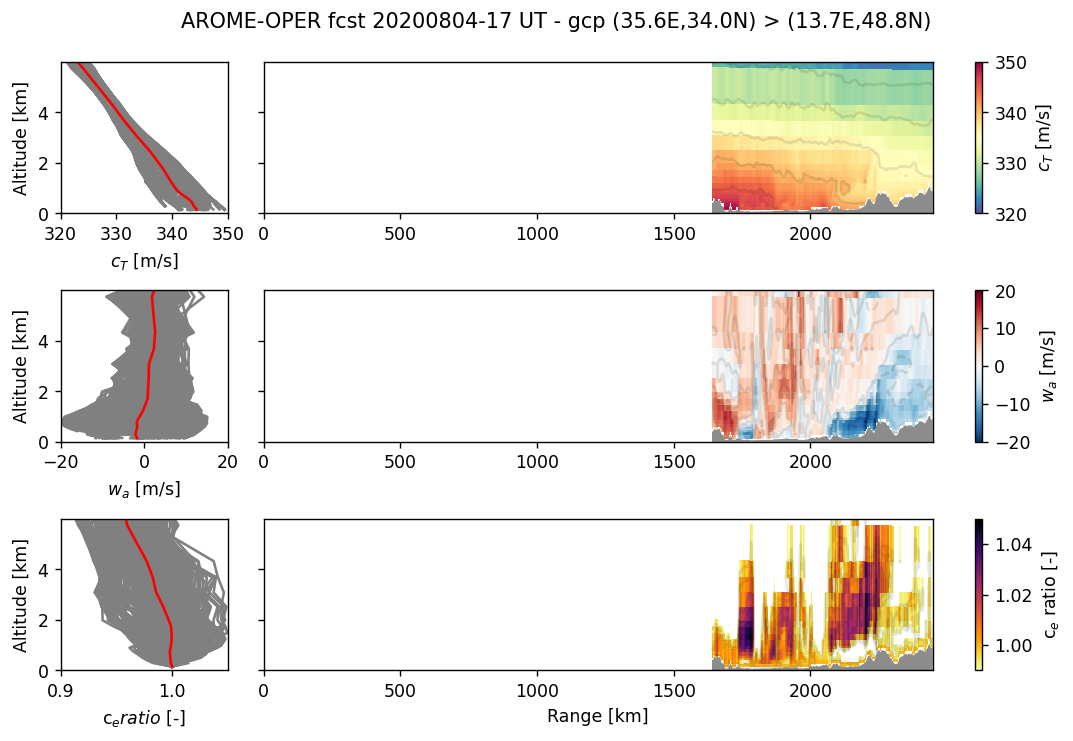

In [31]:
layers = dict()
layers['surface'] = dict(fid='surface', description='Near surface (0-6 km)',
                         z_min=0.0, z_max=6.0, dz=2.0)
# layers['strato'] = dict(fid='strato', description='Troposphere - Stratosphere (0-60 km)',
#                         z_min=0.0, z_max=60.0, dz=10)

for item in layers.keys():
    plot_infrasound_profile(my_atmos, ds_gcp, layers[item])

In [22]:
# from griblib.io.ascii import write_profile

# nr = ds_gcp.dims['distance']
# fid_summary = 'atmosphere_2d_summary.dat'
# line_fmt = '%9.3f %s'

# with open(fid_summary, "w") as summary: 
#     for ir in range(0,nr):
#         dspt =  ds_gcp.isel(distance=ir)
#         dspt['z'] -= float(dspt['z'].sel(hybrid=137))
#         distance = int(np.ceil(ds_gcp.isel(distance=ir).distance/1e3))
#         fid_profile = 'profiles/profile_{:04d}.dat'.format(distance)
#         summary.write('{} {}\n'.format(distance, fid_profile))
#         write_profile(dspt, fid_profile)

# summary.close()

In [23]:
# ds_gcp.to_netcdf('20200804-16-Beirut-I26DE.nc')

In [24]:
# ds_gcp

In [25]:
# x_int = np.arange(ds_gcp.distance.min(), ds_gcp.distance.max(), 1.0e3)
# z_int = np.arange(0.0, 5.0e3, 0.1e3)
# #    _lat = np.arange(ds.latitude.min(), ds.latitude.max(), 2.0)
# #    ds.load()
# #    u_ = u.interp(latitude=_lat, longitude=_lon)
# print(x_int)
# print(z_int)

In [26]:
# xi = xr.DataArray(x_int, dims='range')
# yi = xr.DataArray(z_int, dims='altitude')

In [27]:
# # Interpolate XArray DataSet along great circle path
# ds.load()  # fix otherwise it won't work on recent XArray versions
# ds_gcp = ds.interp(longitude=xlon, latitude=ylat)

# # Assign distance along great circle path to the distance dimension
# ds_gcp = ds_gcp.assign_coords(distance=dist)
# ds_gcp['distance'].attrs = {'long_name': 'distance', 
#                             'units': 'm', 
#                             'positive': 'right', 
#                             'stored_direction': 'increasing',
#                             'standard_name': 'distance'}
# # Store azimuth along great circle path as XArray coordinate
# ds_gcp['azimuth'] = xr.DataArray(azi, coords=[dist], dims=['distance'])
# ds_gcp['azimuth'].attrs = {'long_name': 'azimuth', 
#                            'units': 'degrees', 
#                            'positive': 'right', 
#                            'stored_direction': 'increasing',
#                            'standard_name': 'azimuth'}
# ds_gcp = ds_gcp.set_coords('azimuth')